# Optimizer
---
- 앞서 Batch 단위로 Back Propagation하는 과정을 Stochastic Gradient Descent(SGD)라고 하고, 이러한 과정을 Optimization이라고 했음. 
- SGD 외에도 SGD의 단점을 보완하기 위한 다양한 Optimizer가 있음. 

## MNIST를 이용해 MLP 설계 시 Dropout + ReLU + Batch Normalization + He Uniform Initializattion 적용하기
---
- 지금까지 다양한 요소를 조절해봤음. 그 중에서도 가장 중요한 것은 학습에 이용되는 Optimizer임. 
- Optimizer 중에서도 가장 자주 이용되는 Adam을 이용해 실습해보자. 

In [1]:
'''1. Module Import'''

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
'''2. 딥러닝 모델을 설계할 때 활용하는 장비 확인'''

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using Pytorch version: ', torch.__version__, 'Device: ', DEVICE)

Using Pytorch version:  1.11.0 Device:  cuda


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

In [4]:
'''3. MNIST 데이터 다운로드 (split train / test)'''

train_dataset = datasets.MNIST(root = "../data/MNIST",
                              train = True,
                              download = True,
                              transform = transforms.ToTensor())

test_dataset = datasets.MNIST(root = "../data/MNIST",
                             train = False,
                             transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                         batch_size = BATCH_SIZE,
                                         shuffle = True)

In [5]:
'''4. 데이터 확인하기'''

for (X_train, y_train) in train_loader:
    
    print('X_train: ', X_train.size(), 'type: ', X_train.type())
    print('y_train: ', y_train.size(), 'type: ', y_train.type())
    
    break

X_train:  torch.Size([32, 1, 28, 28]) type:  torch.FloatTensor
y_train:  torch.Size([32]) type:  torch.LongTensor


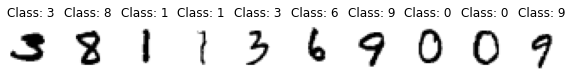

In [6]:
'''5. 데이터 확인하기'''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap='gray_r')
    plt.title('Class: ' + str(y_train[i].item()))

In [7]:
'''6. MLP(Multi Layer Perceptron) 모델 설계하기'''

class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout_prob = 0.5
        self.batch_norm1 = nn.BatchNorm1d(512)
        self.batch_norm2 = nn.BatchNorm1d(256)
        
    def forward(self, x):
        
        x = x.view(-1, 28*28)
        
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training, p=self.dropout_prob)
        
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training, p=self.dropout_prob)
        
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        
        return x

In [8]:
'''7. Optimizer, Objective Function 설정하기'''

import torch.nn.init as init

def weight_init(m):
    
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight.data)

model = Net().to(DEVICE)
model.apply(weight_init)

# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


- optimizer를 정의하는 단 한 줄만 변경하면 됨. 
- Adam은 대체적으로 RMSProp과 Momentum의 특징을 결합하며 다양한 optimizer 중 기본적으로 자주 이용되는 최적화 기법임. 

In [9]:
'''8. MLP 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의'''

def train(model, train_loader, optimizer, log_interval):
    
    model.train()
    
    for batch_idx, (image, label) in enumerate(train_loader):
        
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        
        # 과거에 이용한 Mini-Batch 내에 있는 이미지와 레이블을 바탕으로 계산된 Loss의 Gradient 값이
        # optimizer에 할당되어 있으므로 optimizer의 Gradient를 초기화
        optimizer.zero_grad()
        
        # 장비에 할당한 이미지 데이터를 MLP 모델의 Input으로 이용해 Output 계산
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        
        # 각 파라미터에 할당된 Gradient 값을 이용해 파라미터 값을 업데이트
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(
            Epoch, batch_idx * len(image),
            len(train_loader.dataset), 100. * batch_idx / len(train_loader),
            loss.item()))

In [10]:
'''9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의'''

def evaluate(model, test_loader):
    
    # 학습 과정 또는 학습이 완료된 MLP 모델을 학습 상태가 아닌, 평가 상태로 지정
    model.eval()
    
    # 기존에 정의한 test_loader 내의 데이터를 이용해 Loss 값을 계산하기 위해 test_loss를 0으로 임시 설정
    test_loss = 0
    
    # 학습 과정 또는 학습이 완료된 MLP 모델이 올바른 Class로 분류한 경우를 세기 위해 correct = 0으로 임시 설정
    correct = 0
    
    with torch.no_grad():
        for image, label in test_loader:
            
            image = image.to(DEVICE)
            label = label.to(DEVICE)
    
            output = model(image)
            test_loss += criterion(output, label).item()
            
            prediction = output.max(1, keepdim=True)[1]
            
            # MLP 모델이 최종으로 예측한 클래스 값과 실제 레이블이 의미하는 클래스가 맞으면 correct에 더해 올바르게 예측한 횟수를 저장
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    
    return test_loss, test_accuracy

In [11]:
'''10. MLP 학습을 실행하면서 Train, Test set의 Loss 및 Test set Accuracy를 확인하기'''

for Epoch in range(1, EPOCHS + 1):
    
    train(model, train_loader, optimizer, log_interval=200)
    
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".
         format(Epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000(0%)]	Train Loss: 2.805729
Train Epoch: 1 [6400/60000(11%)]	Train Loss: 0.364043
Train Epoch: 1 [12800/60000(21%)]	Train Loss: 0.202605
Train Epoch: 1 [19200/60000(32%)]	Train Loss: 0.174547
Train Epoch: 1 [25600/60000(43%)]	Train Loss: 0.455091
Train Epoch: 1 [32000/60000(53%)]	Train Loss: 0.477291
Train Epoch: 1 [38400/60000(64%)]	Train Loss: 0.371797
Train Epoch: 1 [44800/60000(75%)]	Train Loss: 0.409901
Train Epoch: 1 [51200/60000(85%)]	Train Loss: 0.320083
Train Epoch: 1 [57600/60000(96%)]	Train Loss: 0.093334

[EPOCH: 1], 	Test Loss: 0.0041, 	Test Accuracy: 96.08 %

Train Epoch: 2 [0/60000(0%)]	Train Loss: 0.070297
Train Epoch: 2 [6400/60000(11%)]	Train Loss: 0.385704
Train Epoch: 2 [12800/60000(21%)]	Train Loss: 0.160311
Train Epoch: 2 [19200/60000(32%)]	Train Loss: 0.442154
Train Epoch: 2 [25600/60000(43%)]	Train Loss: 0.145685
Train Epoch: 2 [32000/60000(53%)]	Train Loss: 0.117920
Train Epoch: 2 [38400/60000(64%)]	Train Loss: 0.316521
Train Epoch: 2 [448

## Reference
---
- 파이썬 딥러닝 파이토치 - 이경택, 방성수, 안상준  
- https://amber-chaeeunk.tistory.com/23